# quick analysis output

KSW 0.550 Targets w/ SN>5 :  46737 / 69633
KBH 0.495 Targets w/ SN>5 :  58877 / 69633
KBH 0.550 Targets w/ SN>5 :  61905 / 69633
KBH 0.605 Targets w/ SN>5 :  62966 / 69633


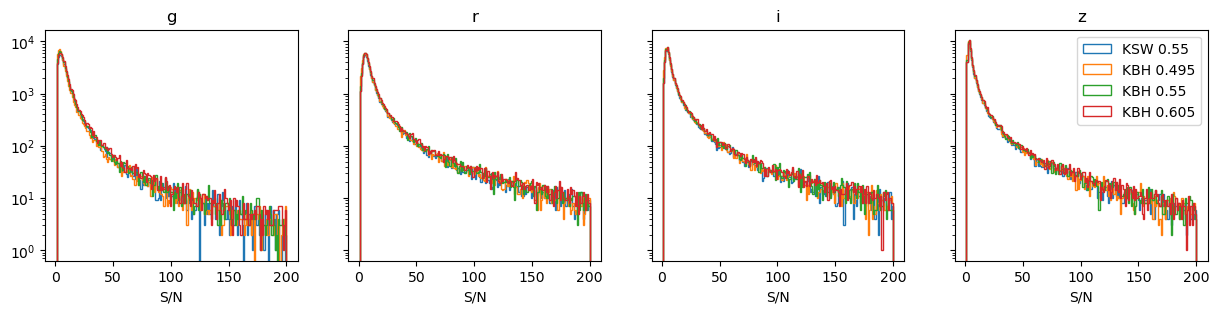

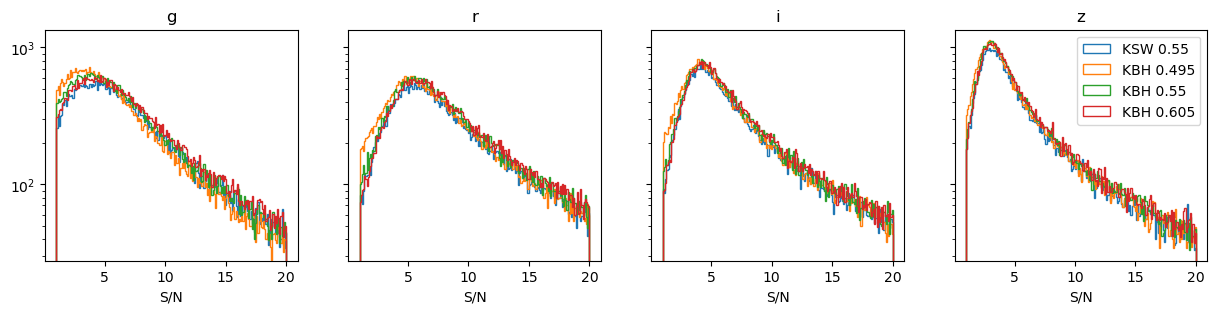

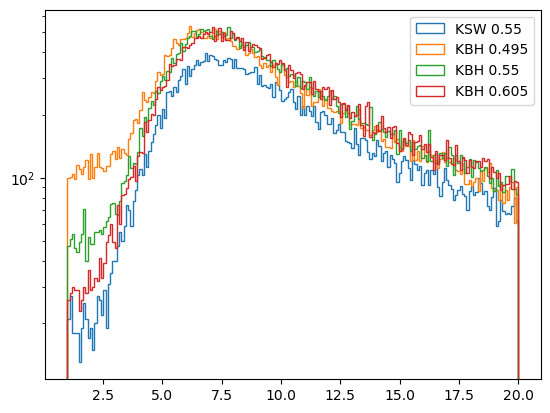

In [10]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt

ksw = Table(fits.open('/pscratch/sd/v/vwetzell/BFD/tile_DES0137-3749_KSW/targets/targets_DES0137-3749_run1.fits')[1].data)
kbh = Table(fits.open('/pscratch/sd/v/vwetzell/BFD/tile_DES0137-3749_KBH/targets/targets_DES0137-3749_run1.fits')[1].data)

kbh090 = Table(fits.open('/pscratch/sd/v/vwetzell/BFD/tile_DES0137-3749_KBH_090/targets/targets_DES0137-3749_run1.fits')[1].data)
kbh110 = Table(fits.open('/pscratch/sd/v/vwetzell/BFD/tile_DES0137-3749_KBH_110/targets/targets_DES0137-3749_run1.fits')[1].data)

# print(len(ksw))
# print(len(kbh))
# print(len(kbh090))
# print(len(kbh110))

print('KSW 0.550 Targets w/ SN>5 : ',
      len(ksw[ksw['moments'][:,0]/np.sqrt(ksw['covariance'][:,0])>5]),'/',len(ksw))
print('KBH 0.495 Targets w/ SN>5 : ',
      len(kbh090[kbh090['moments'][:,0]/np.sqrt(kbh090['covariance'][:,0])>5]),'/',len(kbh090))
print('KBH 0.550 Targets w/ SN>5 : ',
      len(kbh[kbh['moments'][:,0]/np.sqrt(kbh['covariance'][:,0])>5]),'/',len(kbh))
print('KBH 0.605 Targets w/ SN>5 : ',
      len(kbh110[kbh110['moments'][:,0]/np.sqrt(kbh110['covariance'][:,0])>5]),'/',len(kbh110))


bands={0:'g',1:'r',2:'i',3:'z'}

fig,ax = plt.subplots(1,4,sharey=True,figsize=(15,3))
for i in range(4):
    
    plt.yscale('log')
    ax[i].hist(ksw['Mf_per_band'][:,i]/np.sqrt(ksw['cov_Mf_per_band'][:,i]),bins=200,range=(1,200),histtype='step',label='KSW 0.55')
    ax[i].hist(kbh090['Mf_per_band'][:,i]/np.sqrt(kbh090['cov_Mf_per_band'][:,i]),bins=200,range=(1,200),histtype='step',label='KBH 0.495')
    ax[i].hist(kbh['Mf_per_band'][:,i]/np.sqrt(kbh['cov_Mf_per_band'][:,i]),bins=200,range=(1,200),histtype='step',label='KBH 0.55')
    ax[i].hist(kbh110['Mf_per_band'][:,i]/np.sqrt(kbh110['cov_Mf_per_band'][:,i]),bins=200,range=(1,200),histtype='step',label='KBH 0.605')
    if i==3:
        plt.legend()
    ax[i].set_title(bands[i])
    ax[i].set_xlabel('S/N')

plt.savefig('DES0137-3749_SN1-200.png')
plt.show()

fig,ax = plt.subplots(1,4,sharey=True,figsize=(15,3))
for i in range(4):
    
    plt.yscale('log')
    ax[i].hist(ksw['Mf_per_band'][:,i]/np.sqrt(ksw['cov_Mf_per_band'][:,i]),bins=200,range=(1,20),histtype='step',label='KSW 0.55')
    ax[i].hist(kbh090['Mf_per_band'][:,i]/np.sqrt(kbh090['cov_Mf_per_band'][:,i]),bins=200,range=(1,20),histtype='step',label='KBH 0.495')
    ax[i].hist(kbh['Mf_per_band'][:,i]/np.sqrt(kbh['cov_Mf_per_band'][:,i]),bins=200,range=(1,20),histtype='step',label='KBH 0.55')
    ax[i].hist(kbh110['Mf_per_band'][:,i]/np.sqrt(kbh110['cov_Mf_per_band'][:,i]),bins=200,range=(1,20),histtype='step',label='KBH 0.605')
    if i==3:
        plt.legend()
    ax[i].set_title(bands[i])
    ax[i].set_xlabel('S/N')

plt.savefig('DES0137-3749_SN1-20.png')
plt.show()

plt.figure()
plt.yscale('log')
plt.hist(ksw['moments'][:,0]/np.sqrt(ksw['covariance'][:,0]),bins=200,range=(1,20),histtype='step',label='KSW 0.55')
plt.hist(kbh090['moments'][:,0]/np.sqrt(kbh090['covariance'][:,0]),bins=200,range=(1,20),histtype='step',label='KBH 0.495')
plt.hist(kbh['moments'][:,0]/np.sqrt(kbh['covariance'][:,0]),bins=200,range=(1,20),histtype='step',label='KBH 0.55')
plt.hist(kbh110['moments'][:,0]/np.sqrt(kbh110['covariance'][:,0]),bins=200,range=(1,20),histtype='step',label='KBH 0.605')
plt.legend()
plt.savefig('DES0137-3749_tot_SN1-20.png')
plt.show()




In [5]:
kbh110['id']

69633

In [6]:
kbh

id,Mf_per_band,moments,xy,ra,dec,psf_moments,cov_Mf_per_band,covariance,AREA,notes
int64,float32[4],float32[5],float64[2],float64,float64,float32[4],float32[4],float32[15],int64,int64
1311692868,3925.0 .. 129397.0,37084.027 .. 2123520.0,24.561345250156915 .. -37.74273195084055,24.561345250156915,-37.74273195084055,10.35342 .. -0.037987057,103434.0 .. 1319366.0,100637.62 .. 1465397800.0,0,0
1311692867,544.0 .. 11600.0,4918.5938 .. 240734.58,24.072064042613235 .. -37.743661396364246,24.072064042613235,-37.743661396364246,10.359001 .. 0.10200438,105256.0 .. 1579671.0,106176.31 .. 1497914100.0,0,0
1311692866,4079.0 .. 5342.0,4457.844 .. 251885.25,24.714120480637696 .. -37.74172633716881,24.714120480637696,-37.74172633716881,10.236014 .. -0.045305733,126725.0 .. 1560432.0,118517.47 .. 1751390800.0,0,0
1311692865,238.0 .. -1933.0,-185.64436 .. 22448.729,24.334746059088733 .. -37.74227489861193,24.334746059088733,-37.74227489861193,10.379194 .. 0.08185806,82471.0 .. 1333631.0,80999.23 .. 1183883900.0,0,0
1311692864,5006.0 .. 11976.0,9648.689 .. 395171.6,24.402889635374375 .. -37.74230697062142,24.402889635374375,-37.74230697062142,10.481956 .. 0.00020631099,90523.0 .. 1250967.0,86797.71 .. 1061291460.0,0,0
1311692863,2595.0 .. 11856.0,6337.409 .. 213208.67,24.066588905166235 .. -37.7427560343026,24.066588905166235,-37.7427560343026,10.04072 .. 0.10423523,101122.0 .. 1562377.0,105422.01 .. 1518915000.0,0,0
1311692862,1381.0 .. 2272.0,2213.6458 .. 135258.9,24.51317181392104 .. -37.742197665883275,24.51317181392104,-37.742197665883275,10.648016 .. -0.05218773,85678.0 .. 1270624.0,88592.836 .. 1095183100.0,0,0
1311692861,3875.0 .. 9149.0,10107.077 .. 422994.03,24.76452640965066 .. -37.74163647712855,24.76452640965066,-37.74163647712855,10.220103 .. -0.007413827,123091.0 .. 1568531.0,119441.195 .. 1763913200.0,0,0
1311692860,1721.0 .. 3935.0,2532.3696 .. 165789.2,24.306313202712623 .. -37.742323101029896,24.306313202712623,-37.742323101029896,10.351881 .. 0.10099872,82154.0 .. 1172794.0,79586.766 .. 1212849000.0,0,0


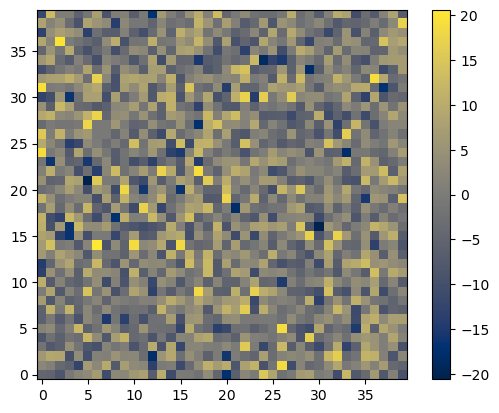

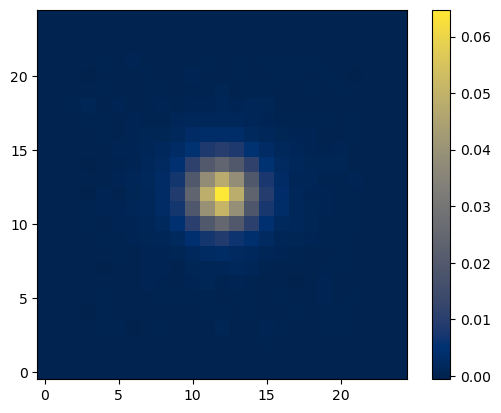

((40, 40), (25, 25))

In [13]:
from astropy.io import fits
from astropy.table import Table
import meds
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

m = meds.MEDS('/pscratch/sd/v/vwetzell/BFD/data/DES0137-3749_r6017p02_r_meds-Y6A2_MEDS_V3.fits.fz')
tile = m.get_cutout(550,2)
psf = m.get_psf(550,2)
plt.figure()
plt.imshow(tile,cmap='cividis',origin='lower')
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(psf,cmap='cividis',origin='lower')
plt.colorbar()
plt.show()

tile.shape,psf.shape


In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import frogress
try:
    import pyfits as pf
except:
    import astropy.io.fits as pf
import frogress


def covariance_scalar_jck(TOTAL_PHI,jk_r, type_c = 'jackknife'):
    #  Covariance estimation
    if type_c == 'jackknife':
        fact=(jk_r-1.)/(jk_r)
    elif type_c=='bootstrap':
        fact=1./(jk_r)
    average=0.
    cov_jck=0.
    err_jck=0.
    for kk in range(jk_r):
        average+=TOTAL_PHI[kk]
    average=average/(jk_r)
    for kk in range(jk_r):
    #cov_jck+=TOTAL_PHI[kk]#*TOTAL_PHI[kk]
        cov_jck+=(-average+TOTAL_PHI[kk])*(-average+TOTAL_PHI[kk])
    err_jck=np.sqrt(cov_jck*fact)
    #average=average*(jk_r)/(jk_r-1)
    return {'cov' : cov_jck*fact,
          'err' : err_jck,
          'mean': average}

def define_jck_mask(length,n_jck):
    import math
    import random
    l_jck = math.ceil(length/n_jck)
    masks =[]
    for i in frogress.bar(range(n_jck)):
        mm = np.array([True]*length)
        mm[i*l_jck:(i+1)*l_jck] = False
        masks.append(mm)
    return masks



def produce_sn(t):
    return t[1].data['moments'][:,0]/np.sqrt(t[1].data['cov_even'][:,0])

def produce_cov(t):
    return (t[1].data['cov_even'][:,0])

def produce_mf(t):
    return t[1].data['moments'][:,0]



def sumPQR_m(tab, stampMode = False, mask = np.array([False])):
    '''Extract the total PQR for the log of probability vs shear
    given an input table with per-detection information. The
    treatment of non-detections can use two possible formulae: 
    when `stampMode=True`, we assume that there is a fixed number
    of target placements, and every row reports either a selected
    galaxy or a non-selected one, the latter including non-detections.
    For `stampMode=False` (or "Poisson" mode), we assume that galaxies
    have been placed by a Poisson process, and that there are 
    rows representing "pseudo-detections" - i.e. reporting the search
    area at a given level of noise.

    The table should have these columns:
    `SELECT`: A column which is non-zero for targets that have been selected,
       and zero for unselected detections and pseudo-detections.
    `AREA`: In stamp mode, this area gives the number of galaxy placements
       represented by the row (which can potentially be >1 if reporting
       non-detected placements.  If the entry is zero or the column is absent,
       a value of 1. will be assumed.

       In Poisson mode, this column should be zero for galaxy detections (whether
       selected or not) and should give the sky area for pseudo-detections.
    `PQR`: Taylor expansion wrt shear of probability (*not* log).
       In stamp mode, this is equal to the *detection* probability per stamp for
       any non-selected row.  In Poisson mode, this is equal to the *detection* 
       probability per unit area for any pseudo-detection.  Targets with p=0 are
       ignored.

    The output is the total log(P), and its derivs w.r.t. shear, for the full
    ensemble.'''

    if colnames['area'] in tab.columns.names:
        area = tab[colnames['area']]
        if stampMode:
            # Every entry is one stamp (at least)
            area = np.maximum(1., area)
    else:
        if stampMode:
            # Every entry is one stamp
            area = np.ones(len(tab), dtype=float)
        else:
            raise ValueError('sumPQR requires AREA column in Poisson mode')

    select = tab[colnames['select']]>0

    pqr = tab[colnames['pqr']]

    if mask.any():
        use = (pqr[:,0] > 0.) & mask
    else:
        #print ('normal')
        use = pqr[:,0] > 0.

    # First sum the log(PQR)'s for selected targets
    # ALL SUMMATIONS EXPLICITLY USE 64 BITS!!
    ss = np.logical_and(use, select)

  
    out = np.sum( logPQR(pqr[ss]), axis=0, dtype=float)

    if stampMode:
        # Sum up log(1-p) for all deselected and pseudo detections
        ss = np.logical_and(use, ~select)
        # Don't use non-detections with 100% detection probability
        ss = np.logical_and(ss, pqr[:,0]<0.999)
      
        nondet = oneMinusPQR(pqr[ss])

        out += np.sum( logPQR(nondet) * area[ss, np.newaxis], axis=0, dtype=float)
    else:
        # Poisson mode: each pseudo-detection contributes
        # log (exp(- p * A)) where p is prob per unit area
        ss = np.logical_and(use, (area>0) & (area!=1))
        # The pseudo-detections should be non-selected as well, 
        # so throw that in for good measure
        ss = np.logical_and(ss, ~select)
        out -= np.sum((pqr[ss]) *area[ss,np.newaxis], axis=0, dtype=float)*1.05

    return out


import numpy as np
from bfd.keywords import *
from bfd.pqr import *




def produce_sn(t):
    try:
        return t[1].data['moments'][:,0]/np.sqrt(t[1].data['covariance'][:,0])
    except:
        return t[1].data['moments'][:,0]/np.sqrt(t[1].data['cov_even'][:,0])
       
def produce_cov(t):
    return (t[1].data['covariance'][:,0])

def produce_mf(t):
    return t[1].data['moments'][:,0]


import pickle
def load_obj(name):
        try:
            with open(name + '.pkl', 'rb') as f:
                return pickle.load(f)#, encoding='latin1')
        except:
            with open(name + '.pkl', 'rb') as f:
                return pickle.load(f, encoding='latin1')


            
            

#out = sumPQR(targets[1].data,stampMode = True)
#g,g_cov = meanShear(out)
#print ('{0:2.6f} +- {1:2.3f}'.format(g[0],np.sqrt(-g_cov[0,0])))
#print ('{0:2.6f} +- {1:2.3f}'.format(g[1],np.sqrt(-g_cov[1,1])))

In [9]:
# paired sims path:
# path_templates = '/global/cscratch1/sd/mgatti/BFD/tile_blends_reference'
path_templates = '/pscratch/sd/v/vwetzell/BFD/tiles_noblends_mask_effects_01_KBH/'

add_labels = [''] #'ISp_','ISm_']
add_labels = ['ISp_','ISm_'] #,'ISm_']
results = dict()

lens = []
for add in add_labels:
    print (add)
    target = path_templates+'/{0}targets_sample_g.fits'.format(add)
    targets = pf.open(target)
    lens.append(len(targets[1].data['ra']))
max_len = np.min(lens)
#rint (lens,lens[1]-lens[0])
    

for add in add_labels:
    print (add)
    target = path_templates+'/{0}targets_sample_g.fits'.format(add)
    targets = pf.open(target)
    results[add] = dict()
    try:
        
#        results[add]['SN'] = produce_sn(targets)[:max_len]
#        results[add]['ra'] = targets[1].data['ra'][:max_len]
#        results[add]['dec'] = targets[1].data['dec'][:max_len]
#        results[add]['photoz'] = targets[1].data['photoz'][:max_len]
#        results[add]['des_id'] = targets[1].data['des_id'][:max_len]
        results[add]['data'] = targets[1].data
    except:
        pass
    try:
    #if 1==1:
        p, q, r, mask= make_pqr(targets[1].data['PQR'][:max_len,:])
#    results[add]['p'] = np.array(p).astype(np.float64)
#    results[add]['q'] = np.array(q).astype(np.float64)
#    results[add]['r'] = np.array(r).astype(np.float64)
        results[add]['mask'] = np.array(mask)[:max_len]
        results[add]['nlost'] = len(mask)-len(mask[mask])
#        results[add]['NOISETIER'] =targets[1].data['NOISETIER'][:max_len]
        results[add]['id'] = targets[1].data['id'][:max_len]
        
    except:
        pass
    try:
        results[add]['sel'] = compute_selection(targets)
    except:
        pass

    pqr = results[add]['data'][colnames['pqr']]
    use = pqr[:,0] > 0.
    ss = np.logical_and(use, results[add]['data']['SELECT'])
        
    results[add]['R00'] = logPQR(pqr[ss])[:,5]





#try:
#    m = pf.open(path_templates+'ISp_targets_sample_g.fits')
#except:
#    m = pf.open(path_templates+'targets_sample_g.fits')
#

ISp_
ISm_
ISp_
ISm_


(array([      0.,       0.,       0.,       0.,       0., 3600377.,
              0.,       0.,       0.,       0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <BarContainer object of 10 artists>)

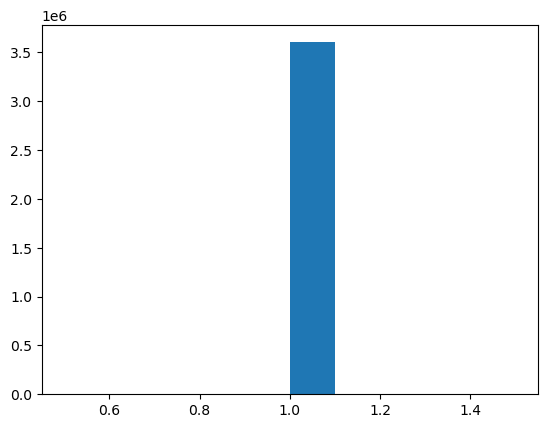

In [10]:
plt.hist(results[add]['data']['NUNIQUE'][results[add]['data']['SELECT']])

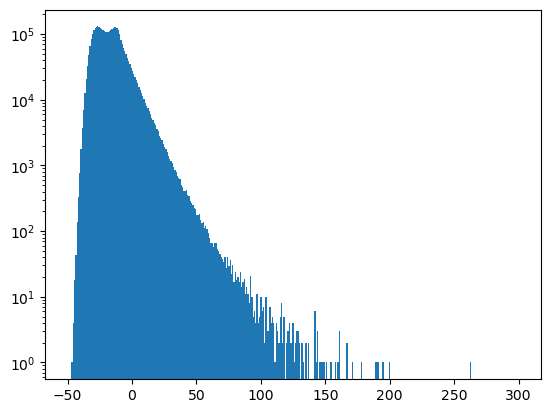

In [11]:
plt.figure()
plt.hist( results[add]['R00'],range=(-50,300),bins=351)
plt.yscale('log')
plt.show()

In [12]:
np.sqrt(-1./np.mean(results[add]['R00']))

0.2426347774454614

In [13]:
def sumPQR_m(tab, stampMode = False, mask = np.array([False])):
    '''Extract the total PQR for the log of probability vs shear
    given an input table with per-detection information. The
    treatment of non-detections can use two possible formulae: 
    when `stampMode=True`, we assume that there is a fixed number
    of target placements, and every row reports either a selected
    galaxy or a non-selected one, the latter including non-detections.
    For `stampMode=False` (or "Poisson" mode), we assume that galaxies
    have been placed by a Poisson process, and that there are 
    rows representing "pseudo-detections" - i.e. reporting the search
    area at a given level of noise.

    The table should have these columns:
    `SELECT`: A column which is non-zero for targets that have been selected,
       and zero for unselected detections and pseudo-detections.
    `AREA`: In stamp mode, this area gives the number of galaxy placements
       represented by the row (which can potentially be >1 if reporting
       non-detected placements.  If the entry is zero or the column is absent,
       a value of 1. will be assumed.

       In Poisson mode, this column should be zero for galaxy detections (whether
       selected or not) and should give the sky area for pseudo-detections.
    `PQR`: Taylor expansion wrt shear of probability (*not* log).
       In stamp mode, this is equal to the *detection* probability per stamp for
       any non-selected row.  In Poisson mode, this is equal to the *detection* 
       probability per unit area for any pseudo-detection.  Targets with p=0 are
       ignored.

    The output is the total log(P), and its derivs w.r.t. shear, for the full
    ensemble.'''

    if colnames['area'] in tab.columns.names:
        area = tab[colnames['area']]
        if stampMode:
            # Every entry is one stamp (at least)
            area = np.maximum(1., area)
    else:
        if stampMode:
            # Every entry is one stamp
            area = np.ones(len(tab), dtype=float)
        else:
            raise ValueError('sumPQR requires AREA column in Poisson mode')

    select = tab[colnames['select']]>0

    pqr = tab[colnames['pqr']]

    if mask.any():
        use = (pqr[:,0] > 0.) & mask
    else:
        #print ('normal')
        use = pqr[:,0] > 0.

    # First sum the log(PQR)'s for selected targets
    # ALL SUMMATIONS EXPLICITLY USE 64 BITS!!
    ss = np.logical_and(use, select)
    m1 = (logPQR(pqr[ss])[:,3]**2<200000**2)

  
    out = np.sum( logPQR(pqr[ss][m1]), axis=0, dtype=float)


    if stampMode:
        # Sum up log(1-p) for all deselected and pseudo detections
        ss = np.logical_and(use, ~select)
        # Don't use non-detections with 100% detection probability
        ss = np.logical_and(ss, pqr[:,0]<0.999)
      
        nondet = oneMinusPQR(pqr[ss])

        out += np.sum( logPQR(nondet) * area[ss, np.newaxis], axis=0, dtype=float)
    else:
        # Poisson mode: each pseudo-detection contributes
        # log (exp(- p * A)) where p is prob per unit area
        ss = np.logical_and(use, (area>0) & (area!=1))
        # The pseudo-detections should be non-selected as well, 
        # so throw that in for good measure
        ss = np.logical_and(ss, ~select)
        out -= np.sum((pqr[ss]) *area[ss,np.newaxis], axis=0, dtype=float)
        #print(np.sum((pqr[ss]) *area[ss,np.newaxis], axis=0, dtype=float))
        
    return out




stampMode = False


out = sumPQR_m(results['ISm_']['data'] ,stampMode = stampMode)
gm,g_cov = meanShear(out)
g_err = np.sqrt(g_cov.diagonal())
#


print ('')
print ('<g1>: {0:2.5f} +- {1:2.5f},   <g2>: {2:2.5f} +- {3:2.5f}'.format(-gm[0],g_err[0],gm[1],g_err[1]))
print ('m_m = {0:2.5f} +- {1:2.5f}'.format((-gm[0]/0.02+1.),g_err[0]/0.02))




out = sumPQR_m(results['ISp_']['data'] ,stampMode = stampMode)
gp,g_cov = meanShear(out)
g_err = np.sqrt(g_cov.diagonal())




print ('')
print ('<g1>: {0:2.5f} +- {1:2.5f},   <g2>: {2:2.5f} +- {3:2.5f}'.format(-gp[0],g_err[0],gp[1],g_err[1]))
print ('m_p = {0:2.5f} +- {1:2.5f}'.format(-gp[0]/0.02-1.,g_err[0]/0.02))


print ('m_diff = {0:2.5f} '.format((-gp[0]+gm[0])/(2*0.02)-1.))




<g1>: -0.02011 +- 0.00013,   <g2>: -0.00007 +- 0.00013
m_m = -0.00570 +- 0.00639

<g1>: 0.02009 +- 0.00013,   <g2>: 0.00007 +- 0.00013
m_p = 0.00425 +- 0.00639
m_diff = 0.00497 


In [15]:
def define_jck_mask_2(id1,id2,n_jck):
    
    id1_ = np.unique(id1)
    #id2_ = np.unique(id2)
    import math
    import random
    
    
    l_jck = math.ceil(len(id1_)/n_jck)
    masks_1 =[]
    masks_2 =[]
    for i in frogress.bar(range(n_jck)):
        xx = id1_[i*l_jck:(i+1)*l_jck]
        
        mm = ~np.in1d(id1,xx)
        masks_1.append(mm)
        
        mm = ~np.in1d(id2,xx)
        masks_2.append(mm)
    return masks_1,masks_2

In [16]:
n_jck = 100
m__0,m__1 = define_jck_mask_2(np.arange(len(results['ISp_']['data']['id_simulated_PSF'])),np.arange(len(results['ISm_']['data']['id_simulated_PSF'])),n_jck)



#m_ = define_jck_mask(results['ISp_']['data'].shape[0],100)

gp_ = []

for m__ in frogress.bar(m__0):
    out = sumPQR_m(results['ISp_']['data'] ,stampMode = False,mask = m__)
    g,g_cov = meanShear(out)

    #g,_ = compute_g(p[m__],q[m__,:],r[m__,:,:])
    gp_.append(g)


gm_ = []
for m__ in frogress.bar(m__1):
    out = sumPQR_m(results['ISm_']['data'] ,stampMode = False,mask = m__)
    g,g_cov = meanShear(out)
    #g,_ = compute_g(p[m__],q[m__,:],r[m__,:,:])
    gm_.append(g)



d = covariance_scalar_jck((-np.array(gp_)+np.array(gm_))/(2*0.02)-1.,n_jck,type_c = 'jackknife') #n_jck,type_c = 'jackknife')


print ('')
print ('m_diff = {0:2.5f} +- {1:2.9f}'.format((-gp[0]+gm[0])/(2*0.02)-1.,d['err'][0]))

100.0% | [##########] | Progress: 100 / 100 | Time: 2min5s | ETA: --0ss
m_diff = 0.00497 +- 0.003889761


In [6]:
try:
    import pyfits as pf
except:
    import astropy.io.fits as pf
#m = pf.open('/global/cscratch1/sd/mgatti/BFD/tile_blends_reference_1arcs_deblender_final/ISp_targets_sample_g.fits')
for i in range(2):
    m = pf.open('/pscratch/sd/v/vwetzell/BFD/tiles_noblends_vernon/noisetiers_{0}.fits'.format(i))
    m[1].data['PQR_SEL']

In [7]:
# Function and executable that will assign noise tiers
# and interpolate selection PQR's to target files.

import sys
import numpy as np
from astropy.table import Table
import bfd
import argparse

target = '/pscratch/sd/v/vwetzell/BFD/tiles_noblends_vernon/ISp_targets_sample_g.fits'


print (i)

tab = Table.read(target)


1


In [8]:
target = '/pscratch/sd/v/vwetzell/BFD/tiles_noblends_vernon/ISm_targets_sample_g.fits'
m = pf.open(target)
mask = m[1].data['NOISETIER'] == 1
len(mask[mask])

3562832

In [9]:

i=1
px = '/pscratch/sd/v/vwetzell/BFD/tiles_noblends_vernon/noisetiers_{0}.fits'.format(i)
tc = bfd.TierCollection.load(px)
#tc.assignPQRSel(tab)
#tab.write(target, overwrite=True)
m = pf.open(px)

In [10]:
m[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   88 / length of dimension 1                          
NAXIS2  =                   33 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
TIER_NUM=                    0                                                  
EXTNAME = 'TIER0000'                                                            
COVMXMX =         145224.03125                                                  
COVMXMY =                  0.0                                                  
COVMYMY =         145224.031

In [11]:
from bfd import Moment
tab = Table.read(target)
# ??? Need to alter the below if we are using magnification or colors
covs = None
for k in 'COV_EVEN','cov_even','covariance',colnames['covariance']:
    if k in tab.colnames:
        covs = tab[k]
        

assignments = tc.assign(covs)
m = Moment()
fluxes = None
for k in 'moments','MOMENTS':
    if k in tab.colnames:
        fluxes = tab[k][:,m.M0]
if fluxes is None:
    raise ValueError('No MOMENTS column in table')



[1 2] [0 0 0 ... 0 0 0] [1 1 1 ... 1 1 1]
Tier 0 gets 85447 targets
Tier 1 gets 3562832 targets


In [12]:

# Create or read columns for PQR, tier number, select.
# Enforce uppercase
if 'pqr' in tab.colnames:
    pqr = tab['pqr'].data.copy()
    del tab['pqr']
elif colnames['pqr'] in tab.colnames:
    pqr = tab[colnames['pqr']].data.copy()
else:
    pqr = np.zeros( (covs.shape[0],6), dtype=float)

if 'select' in tab.colnames:
    select = tab['select'].data.copy()
    del tab['select']
elif 'SELECT' in tab.colnames:
    select = tab['SELECT'].data.copy()
else:
    select = np.zeros(covs.shape[0], dtype=bool)

if 'noisetier' in tab.colnames:
    targetTier = tab['noisetier'].data.copy()
    del tab['noisetier']
elif colnames['tierNumber'] in tab.colnames:
    targetTier = tab[colnames['tierNumber']].data.copy()
else:
    targetTier = np.ones(covs.shape[0], dtype=int) * -1


In [13]:

for i,t in enumerate(tc.tiers):
    print (i,t.pqrNodes)
    if t.id not in assignments:
        # No targets for this tier
        continue
    use = assignments[t.id]
    targetTier[use] = t.id
    # Find objects failing selection
    inRange = np.ones_like(use, dtype=bool)
    if t.fluxMin is not None:
        inRange = np.logical_and(inRange, fluxes[use] >= t.fluxMin)
    if t.fluxMax is not None:
        inRange = np.logical_and(inRange, fluxes[use] < t.fluxMax)
    select[use[inRange]] = True
    use = use[~inRange]
    select[use] = False
    pqr[use,:] = t.pqrSel(covs[use])

0 [[ 1.65408582e-03  0.00000000e+00  0.00000000e+00  3.82125904e-08
   0.00000000e+00  3.82125904e-08]
 [ 1.65415846e-03  0.00000000e+00  0.00000000e+00  1.51334561e-07
   0.00000000e+00  1.51334561e-07]
 [ 1.65414962e-03 -2.74647860e-09 -1.85037166e-13  1.81923966e-07
   8.28374424e-13  1.35770662e-07]
 [ 1.65413704e-03  0.00000000e+00  0.00000000e+00  9.59766737e-08
   0.00000000e+00  9.59766737e-08]
 [ 1.65414589e-03 -1.77184611e-09  1.79856130e-13  1.15942690e-07
  -5.02116849e-13  8.64576108e-08]
 [ 1.65410864e-03  0.00000000e+00  0.00000000e+00  6.04453163e-08
   0.00000000e+00  6.04453163e-08]
 [ 1.65410526e-03 -1.15269250e-09 -1.92734717e-12  7.29312504e-08
   9.41942791e-12  5.49425216e-08]
 [ 1.65408582e-03  0.00000000e+00  0.00000000e+00  3.82086114e-08
   0.00000000e+00  3.82086114e-08]
 [ 1.65407232e-03 -7.65810804e-10  4.47789944e-13  4.54691538e-08
   5.46229728e-13  3.52391254e-08]
 [ 1.65415707e-03  0.00000000e+00  0.00000000e+00  1.20685229e-07
   0.00000000e+00  1.20

In [71]:
for i in range(38):
    tc.tiers[i].pqrNodes 

In [131]:
m = pf.open(target)

In [ ]:
covariance